In [1]:
import numpy as np
from source.Files_operating import read_sht_data

shtRipper v1.3


In [159]:
F_ID = 44350
dir_path = "C:/Users/f.belous/Work/Projects/Plasma_analysis/data/sht/G-ELM/"  
# D:/Edu/Lab/Projects/Plasma_analysis/data/sht/G-ELM/ | C:/Users/f.belous/Work/Projects/Plasma_analysis/data/sht/G-ELM/

df = read_sht_data(f'sht{F_ID}', dir_path)
df = df.rename(columns={"ch1": "d_alpha"})
df["sxr"] = read_sht_data(f'sht{F_ID}', dir_path, data_name="SXR 50 mkm").ch1
# dbs = read_dataFile(f'data/dbs/{F_ID} DBS.dat')
# mgd_data_1
# mgd_data_3
# mgd_data_2
df.describe()

,t,d_alpha,sxr
count,393216.000000,393216.000000,393216.000000
mean,0.196608,0.178219,0.174287
std,0.113512,0.273904,0.246380
min,0.000000,-0.472888,-0.120139
25%,0.098304,0.012781,0.061348
50%,0.196607,0.046011,0.063904
75%,0.294911,0.334856,0.089465
max,0.393215,4.820903,3.279543


In [160]:
d_alpha = df.d_alpha.to_numpy()
sxr = df.sxr.to_numpy()

In [161]:
d_alpha_d1 = np.diff(d_alpha)
sxr_d1 = np.diff(sxr)

In [162]:
from scipy import signal

b, a = signal.butter(5, 0.05)
d_alpha_f = signal.filtfilt(b, a, d_alpha_d1)
sxr_f = signal.filtfilt(b, a, sxr_d1)

In [163]:
da_f_q, da_f_std = np.quantile(d_alpha_f, 0.7), d_alpha_f.std()
sxr_f_q, sxr_f_std = np.quantile(sxr_f, 0.8), sxr_f.std()

In [141]:
def get_boarders(data: np.array, loc_max_ind=None, scale=1.5):
    loc_max_ind = np.argmax(data)
    dist_ind = np.argsort(np.abs(data - data[loc_max_ind] / scale))
    return Slice(dist_ind[dist_ind <= loc_max_ind][0], dist_ind[dist_ind >= loc_max_ind][0])


class Slice:
    def __init__(self, start_index=0, end_index=0):
        self.l = start_index
        self.r = end_index
        self.mark = 1.0

    def set_boarders(self, start_index: int, end_index: int) -> None:
        self.l = start_index
        self.r = end_index

    def set_mark(self, mark: int) -> None:
        self.mark = mark

    def copy(self, other):
        self.l = other.l
        self.r = other.r
        self.mark = other.mark

    def check_length(self, len_edge: int) -> bool:
        return self.r - self.l > len_edge

    def check_dist(self, other, dist_edge: int) -> bool:
        return other.l - self.r > dist_edge

    def collide_slices(self, other, dist_edge: int) -> bool:
        if not self.check_dist(other, dist_edge):
            self.r = other.r
            return True
        return False

    def step(self) -> None:
        self.r += 1

    def move(self, delta: int) -> None:
        self.r += delta
        self.l += delta

    def expand(self, delta: int) -> None:
        self.r += delta
        self.l -= delta

    def collapse_boarders(self) -> None:
        self.l = self.r

    def is_null(self) -> bool:
        return self.l == self.r

In [142]:
class Signal_meta:
    def __init__(self, chanel_name="da", processing_flag=False, 
                 quantile_edge=0.0, std_edge=1.0, 
                 length_edge=10, distance_edge=10, scale=1.5, step_out=10, 
                 std_bottom_edge=0, std_top_edge=1, d_std_bottom_edge=3, d_std_top_edge=6):
        self.name = chanel_name
        self.proc_fl = processing_flag
        
        self.len_edge = length_edge
        self.dist_edge = distance_edge
        self.scale = scale
        self.step_out = step_out
        
        self.q = quantile_edge
        self.std = std_edge
        
        self.d_q = quantile_edge
        self.d_std = std_edge

        self.std_top = std_top_edge
        self.std_bottom = std_bottom_edge
        self.d_std_top = d_std_top_edge
        self.d_std_bottom = d_std_bottom_edge
        
    def set_statistics(self, data: np.array, data_diff: np.array, percentile: float, d_percentile: float, std_bottom_edge=0, std_top_edge=1, d_std_bottom_edge=3, d_std_top_edge=6):
        self.q = np.quantile(data, percentile)
        self.std = data.std()
        self.std_top = std_top_edge
        self.std_bottom = std_bottom_edge
        self.d_q = np.quantile(data_diff, percentile)
        self.d_std = data_diff.std()
        self.d_std_top = d_std_top_edge
        self.d_std_bottom = d_std_bottom_edge

    def set_edges(self, length_edge=10, distance_edge=10, scale=1.5, step_out=10):
        self.len_edge = length_edge
        self.dist_edge = distance_edge
        self.scale = scale
        self.step_out = step_out

In [143]:
def proc_slices(mark_data: np.array, data: np.array, data_diff: np.array, meta: Signal_meta) -> np.array:  # data: np.array, , scale=1.5 , step_out=10
    proc_slice = Slice(0, 50)
    cur_slice = Slice(0, 51)
    f_fragment = False

    res_mark = np.copy(mark_data)
    res_mark[cur_slice.l: cur_slice.r] = 0.0
    cur_slice.collapse_boarders()
    proc_slice.copy(cur_slice)

    c = 0
    
    while cur_slice.r < res_mark.shape[0]:
        if res_mark[cur_slice.r] == 1.0:
            if not f_fragment:
                f_fragment = True
        elif f_fragment:
            # print(start_ind, end_ind)
            if not cur_slice.check_length(meta.len_edge):
                res_mark[cur_slice.l: cur_slice.r] = 0.0
            elif not proc_slice.collide_slices(cur_slice, meta.dist_edge):
                if meta.proc_fl and meta.scale > 1:
                    res_mark[proc_slice.l: proc_slice.r] = 0.0
                    start_ind = proc_slice.l if data_diff[proc_slice.l] > 0 else proc_slice.r
                    proc_slice = proc_boarders(data, data_diff, start_ind, meta.scale)
                    
                    cur_slice = Slice(proc_slice.r, proc_slice.r)
                
                proc_slice.expand(meta.step_out)

                if meta.proc_fl and abs(data_diff[proc_slice.l:proc_slice.r].max() - meta.d_q) < meta.d_std_top * meta.d_std and \
                   abs(data_diff[proc_slice.l:proc_slice.r].min() - meta.d_q) < meta.d_std_top * meta.d_std:
                    proc_slice.set_mark(0)

                if meta.name == "sxr" and abs(data_diff[proc_slice.l:proc_slice.r].max() - meta.d_q) < meta.d_std:
                    proc_slice.set_mark(1)
                
                res_mark[proc_slice.l: proc_slice.r] = proc_slice.mark
                c += proc_slice.mark
                
                proc_slice.copy(cur_slice)
            f_fragment = False
            cur_slice.collapse_boarders()
        elif not f_fragment:
            cur_slice.collapse_boarders()
            if proc_slice.is_null():
                proc_slice.copy(cur_slice)
    
        cur_slice.step()
    print(c)

    return res_mark

In [144]:
def get_peaks(data: np.array, s_i: int) -> np.array:
    peaks_ind = []
    loc_max = data.min()
    m_v = data.mean()
    loc_max_ind = 0
    increase_fl = False
    for i in range(data.shape[0] - 1):
        if loc_max < data[i]:
            increase_fl = True
            loc_max = data[i]
            loc_max_ind = i
        elif abs((loc_max - data[i]) / (loc_max + 1e-10)) > 0.5 and increase_fl:
            if abs(loc_max) > 5 * abs(m_v + 1e-10):
                peaks_ind.append(loc_max_ind)
            # print(s_i + loc_max_ind, abs((loc_max - data[i]) / loc_max), abs((loc_max - m_v) / m_v))  # len(peaks_ind),
            increase_fl = False

        if not increase_fl or data[i] < data[i + 1]:
            loc_max = data[i]
            loc_max_ind = i
    return np.array(peaks_ind)

def get_boarders_d2(data:np.array, diff_data: np.array, s_i: int, scale=1.5):
    d2_data = np.diff(diff_data)
    peaks_ind = get_peaks(d2_data, s_i)

    if len(peaks_ind) == 0:
        return Slice(0, diff_data.shape[0])
    elif len(peaks_ind) == 1:
        scale_slice = get_boarders(data, scale=scale)
        if peaks_ind[0] < diff_data.shape[0] - peaks_ind[0]:
            if peaks_ind[0] - scale_slice.r > 0:
                return Slice(peaks_ind[0], scale_slice.r)
            else:
                return Slice(peaks_ind[0], diff_data.shape[0])
        elif peaks_ind[0] > diff_data.shape[0] - peaks_ind[0]:
            if peaks_ind[0] - scale_slice.l > 0:
                return Slice(scale_slice.l, peaks_ind[0])
            else:
                return Slice(0, peaks_ind[0])

    return Slice(peaks_ind[0], peaks_ind[-1])

def proc_boarders(data: np.array, data_diff: np.array, start_ind: int, scale=1.5) -> Slice:
    step = 5
    
    diff_coeff = 1
    if data_diff[start_ind] < 0:
        diff_coeff = -1
    
    cur_ind = (start_ind + diff_coeff * step) if 0 < start_ind + diff_coeff * step < data.shape[0] else start_ind
    while 0 < cur_ind + diff_coeff * step < data.shape[0] and data_diff[cur_ind] * data_diff[cur_ind + diff_coeff * step] > 0:
        cur_ind += diff_coeff * step

    # print(cur_ind - 3 * step, cur_ind + 3 * step, end=" ")
    max_ind = np.argmax(data[max(cur_ind - 3 * step, 0): min(cur_ind + 3 * step, data.shape[0])]) + cur_ind - step
    length = max(abs(max_ind - start_ind), 3 * step)
    # print(max_ind, length)

    # print(max_ind - length, max_ind + 2 * length, end=" ")
    res_slice = get_boarders_d2(data[max(max_ind - length, 0): min(max_ind + 2 * length, data.shape[0])], data_diff[max(max_ind - length, 0): min(max_ind + 2 * length, data.shape[0])], max(max_ind - length, 0), scale=scale)  # get_boarders(data[max_ind - length: max_ind + 2 * length], loc_max_ind=length) | Slice(0, 3 * length)
    res_slice.move(max_ind - length)
    # print(res_slice.l, res_slice.r)

    # add checking diff on right & left boarder (cut on D2 peaks) - done
    # add dtw classification (None | ELM | LSO)

    print(res_slice.l, res_slice.r, end=" ")
    print(abs(data_diff[res_slice.l:res_slice.r].max() - np.quantile(data_diff, 0.7)), data_diff.std())
    
    return res_slice

In [164]:
meta_da = Signal_meta(chanel_name="da", processing_flag=True)
meta_da.set_statistics(d_alpha, d_alpha_f, 0.7, 0.7, d_std_bottom_edge=1.5, d_std_top_edge=2.7)
meta_da.set_edges(length_edge=15, distance_edge=30)

meta_da_2 = Signal_meta(chanel_name="da", processing_flag=False)
meta_da_2.set_statistics(d_alpha, d_alpha_f, 0.7, 0.7, d_std_bottom_edge=1.5, d_std_top_edge=2.5)
meta_da_2.set_edges(length_edge=15, distance_edge=30)

meta_sxr = Signal_meta(chanel_name="sxr", processing_flag=True)
meta_sxr.set_statistics(sxr, sxr_f, 0.8, 0.8, d_std_bottom_edge=7.0, d_std_top_edge=15.0)
meta_sxr.set_edges(length_edge=10, distance_edge=30, scale=0)

In [165]:
mark_data = np.zeros(d_alpha_f.shape)
mark_data[abs(d_alpha_f - meta_da.d_q) > meta_da.d_std * meta_da.d_std_bottom] = 1
mark_d_alpha = proc_slices(mark_data, d_alpha, d_alpha_f, meta_da)

mark_data = np.zeros(d_alpha_f.shape)
mark_data[abs(d_alpha_f - meta_da_2.d_q) > meta_da_2.d_std * meta_da_2.d_std_bottom] = 1
mark_d_alpha_2 = proc_slices(mark_data, d_alpha, d_alpha_f, meta_da_2)

mark_data = np.zeros(d_alpha_f.shape)
mark_data[abs(sxr_f - meta_sxr.d_q) > meta_sxr.d_std * meta_sxr.d_std_bottom] = 1
mark_sxr = proc_slices(mark_data, sxr, sxr_f, meta_sxr)

110495 110545 0.011245496567654794 0.002028633439037157
122365 122515 0.004395792455770861 0.002028633439037157
132072 132177 0.0926531636673565 0.002028633439037157
131981 132482 0.0926531636673565 0.002028633439037157
145292 145397 0.004752379734460427 0.002028633439037157
145449 145503 0.00304165508186304 0.002028633439037157
145513 145603 0.003435585568408487 0.002028633439037157
145656 145832 0.004446256859272253 0.002028633439037157
145872 145917 0.00011986136406105478 0.002028633439037157
145976 146041 0.0045486588011413205 0.002028633439037157
146279 146314 0.0017462157091772735 0.002028633439037157
146582 146624 0.0066329841930868865 0.002028633439037157
146642 146698 0.003379980341574356 0.002028633439037157
146849 146962 0.0036556530577802763 0.002028633439037157
146962 147047 0.0037779462803271035 0.002028633439037157
147282 147325 0.0011149535522352798 0.002028633439037157
147541 147626 0.004521784528458201 0.002028633439037157
147788 147827 0.0016098530800399608 0.0020286

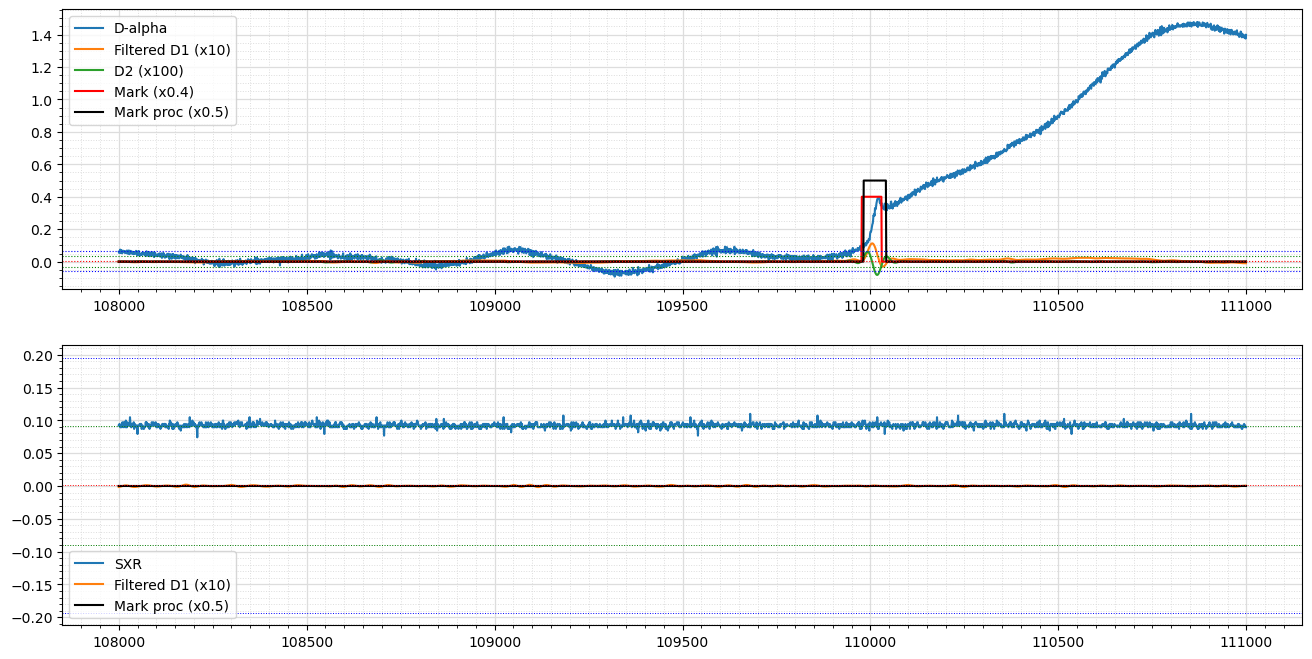

ELM fragment (0.108 - 0.111 ms)



In [147]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

def get_d2_peaks(diff_data: np.array, mark_data: np.array, s_i: int) -> np.array:
    l_ = 0
    fr_fl = False
    peaks_ind = []
    for i in range(mark_data.shape[0]):
        if mark_data[i] == 1 and not fr_fl:
            fr_fl = True
            l_ = i
        elif fr_fl and mark_data[i] == 0:
            fr_fl = False
            d2_data = np.diff(diff_data)
            res = get_peaks(d2_data[l_-10:i+30], s_i) + l_-10
            peaks_ind += res.tolist()
    peaks_ind = np.array(peaks_ind)
    return peaks_ind, d2_data[peaks_ind]

mode_plotting = 1  # int(input("Input visualising mode [ 0 - manual | 1 - only marked ]:"))
# mode_marking = int(input("Input marking mode (0 - manual | 1 - semiauto): ").strip().split()[0])
l_edge = 0  # int(input(f"Input start index [0:{df.shape[0]//1000*1000}]: ").strip().split()[0])
# print("---")
step = 2000
width = 3000

step_away = 10

while l_edge < df.shape[0]:
    r_edge = min(l_edge + width, df.shape[0] - 1)
    
    if mode_plotting == 1 and sum(mark_d_alpha[l_edge:r_edge]) == 0 and sum(mark_sxr[l_edge:r_edge]) == 0:
        l_edge += step
        continue
    
    fig, [ax1, ax2] = plt.subplots(2, 1)

    fig.set_figwidth(16)
    fig.set_figheight(8)

    ax1.plot(range(l_edge, r_edge), d_alpha[l_edge:r_edge], label="D-alpha")
    # ax1.plot(range(l_edge, r_edge), d_alpha_d1[l_edge:r_edge], label="Diff 1")
    ax1.plot(range(l_edge, r_edge), d_alpha_f[l_edge:r_edge] * 10, label="Filtered D1 (x10)")
    ax1.plot(range(l_edge, r_edge), np.diff(d_alpha_f)[l_edge:r_edge] * 100, label="D2 (x100)")

    # x, y = get_d2_peaks(d_alpha_f[l_edge:r_edge], mark_d_alpha[l_edge:r_edge], l_edge)
    # x = x + l_edge
    # print(len(x), x, y)
    # ax1.scatter(x, y * 100, s=20)

    ax1.plot(range(l_edge, r_edge), mark_d_alpha_2[l_edge:r_edge] * 0.4, label="Mark (x0.4)", color="red")
    ax1.plot(range(l_edge, r_edge), mark_d_alpha[l_edge:r_edge] * 0.5, label="Mark proc (x0.5)", color="black")
    ax1.axhline(meta_da.d_q * 10, color="red", linestyle=':', linewidth=0.8)
    ax1.axhline((meta_da.d_q + meta_da.d_std * meta_da.d_std_bottom) * 10, color="green", linestyle=':', linewidth=0.8)
    ax1.axhline((meta_da.d_q - meta_da.d_std * meta_da.d_std_bottom) * 10, color="green", linestyle=':', linewidth=0.8)
    ax1.axhline((meta_da.d_q + meta_da.d_std * meta_da.d_std_top) * 10, color="blue", linestyle=':', linewidth=0.8)
    ax1.axhline((meta_da.d_q - meta_da.d_std * meta_da.d_std_top) * 10, color="blue", linestyle=':', linewidth=0.8)
    ax1.grid(which='major', color='#DDDDDD', linewidth=0.9)
    ax1.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax1.legend()

    ax2.plot(range(l_edge, r_edge), sxr[l_edge:r_edge], label="SXR")
    # ax2.plot(range(l_edge, r_edge), sxr_d1[l_edge:r_edge], label="Diff 1")
    ax2.plot(range(l_edge, r_edge), sxr_f[l_edge:r_edge] * 10, label="Filtered D1 (x10)")
    ax2.plot(range(l_edge, r_edge), mark_sxr[l_edge:r_edge] * 0.5, label="Mark proc (x0.5)", color="black")
    ax2.axhline(meta_sxr.d_q * 10, color="red", linestyle=':', linewidth=0.7)
    ax2.axhline((meta_sxr.d_q + meta_sxr.d_std * meta_sxr.d_std_bottom) * 10, color="green", linestyle=':', linewidth=0.7)
    ax2.axhline((meta_sxr.d_q - meta_sxr.d_std * meta_sxr.d_std_bottom) * 10, color="green", linestyle=':', linewidth=0.7)
    ax2.axhline((meta_sxr.d_q + meta_sxr.d_std * meta_sxr.d_std_top) * 10, color="blue", linestyle=':', linewidth=0.7)
    ax2.axhline((meta_sxr.d_q - meta_sxr.d_std * meta_sxr.d_std_top) * 10, color="blue", linestyle=':', linewidth=0.7)

    ax2.grid(which='major', color='#DDDDDD', linewidth=0.9)
    ax2.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    ax2.minorticks_on()
    ax2.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax2.legend()
    plt.show()

    # res = list(map(int, input(f"Input index pairs of ELM fragments ({df.t[l_edge]} - {df.t[r_edge]} ms):\n").strip().split()))
    # for i in range(0, len(res), 2):
    #     board_ind = [res[i], res[i+1]]

    #     mark = float(input("Input mark to set [ 0 | 1 | 2 ]: "))
        
    #     if mode_marking and mark > 0:
    #         board_ind = get_borders(df.loc[res[i]:res[i + 1], "ch1"].to_numpy(), scale=1.5)
    #         board_ind[0] = max(board_ind[0] - step_away + res[i], 0)
    #         board_ind[1] += res[i]
        
    #     df.loc[board_ind[0]:board_ind[1], "ch1_marked"] = mark

    print(f"ELM fragment ({df.t[l_edge]} - {df.t[r_edge]} ms)\n")
    break
    # input(f"ELM fragment ({df.t[l_edge]} - {df.t[r_edge]} ms)\n")

    plt.close()
    plt.clf()
    l_edge += step

# 217500

---
### Reporting sync ELM program
---

In [148]:
import copy

def get_slices(mark_data: np.array):
    cur_slice = Slice(0, 1)
    f_fragment = False

    slices_list = []
    
    while cur_slice.r < mark_data.shape[0]:
        if mark_data[cur_slice.r] == 1.0:
            if not f_fragment:
                f_fragment = True
        elif f_fragment:
            slices_list.append(copy.copy(cur_slice))
            f_fragment = False
            cur_slice.collapse_boarders()
        elif not f_fragment:
            cur_slice.collapse_boarders()
        cur_slice.step()

    return slices_list

In [166]:
sxr_slices = get_slices(mark_sxr)
deltas = np.zeros(len(sxr_slices))

print(f"Signal #{F_ID}")
print(f"SXR falls: {len(sxr_slices)}")
print("-----")

for sl_i in range(len(sxr_slices)):
    da_slices = get_slices(mark_d_alpha[min(sxr_slices[sl_i].l - 500, mark_d_alpha.shape[0]): min(sxr_slices[sl_i].r + 1000, mark_d_alpha.shape[0])])

    if len(da_slices) == 0:
        deltas[sl_i] = np.nan
        print(f"SXR fall - {((sxr_slices[sl_i].r - sxr_slices[sl_i].l) // 2 + sxr_slices[sl_i].l) / 1e3} ms -- No ELM on D-alpha")
    else:
        ind = 0
        while sxr_slices[sl_i].r - (da_slices[ind].r + sxr_slices[sl_i].l - 500) > 0 and ind + 1 < len(da_slices):
            ind += 1
        # print(ind)
        # for da_sl in da_slices:
        #     print((da_sl.l + sxr_slices[sl_i].l - 500) / 1e3, (da_sl.r + sxr_slices[sl_i].l - 500) / 1e3)
        deltas[sl_i] = (da_slices[ind].l - 500 - (sxr_slices[sl_i].r - sxr_slices[sl_i].l) // 2) / 1e3
        print(f"SXR fall - {((sxr_slices[sl_i].r - sxr_slices[sl_i].l) // 2 + sxr_slices[sl_i].l) / 1e3} ms -- ELM on D-alpha: delta = {deltas[sl_i]} ms")


print("-----")
print(f"Deltas info: mean = {np.nanmean(deltas)} ms, std = {np.nanstd(deltas)}")
print(f"SXR falls w/o sync ELM in nearest area (-0.5 ms; 1 ms): {np.count_nonzero(np.isnan(deltas))}")

Signal #44350
SXR falls: 9
-----
SXR fall - 132.082 ms -- ELM on D-alpha: delta = -0.112 ms
SXR fall - 171.117 ms -- ELM on D-alpha: delta = -0.032 ms
SXR fall - 181.269 ms -- ELM on D-alpha: delta = -0.018 ms
SXR fall - 184.746 ms -- ELM on D-alpha: delta = 0.003 ms
SXR fall - 191.575 ms -- ELM on D-alpha: delta = -0.136 ms
SXR fall - 200.967 ms -- ELM on D-alpha: delta = -0.014 ms
SXR fall - 204.237 ms -- ELM on D-alpha: delta = -0.021 ms
SXR fall - 210.685 ms -- ELM on D-alpha: delta = -0.018 ms
SXR fall - 215.473 ms -- ELM on D-alpha: delta = -0.006 ms
-----
Deltas info: mean = -0.039333333333333345 ms, std = 0.04651164728681767
SXR falls w/o sync ELM in nearest area (-0.5 ms; 1 ms): 0


In [115]:
def process_fragments(data: np.array, mark_data: np.array, length_edge=10, distance_edge=25, scale=1.5, step_out=10) -> np.array:
    proc_slice = Slice(0, 0)
    cur_slice = Slice(0, 1)
    f_fragment = False

    while cur_slice.r < mark_data.shape[0]:
        if mark_data[cur_slice.r] == 1.0:
            if not f_fragment:
                f_fragment = True
        elif f_fragment:
            # print(start_ind, end_ind)
            if scale <= 1:
                if not cur_slice.check_length(length_edge):
                    mark_data[cur_slice.l: cur_slice.r] = 0.0
                elif not proc_slice.collide_slices(cur_slice, distance_edge):
                    mark_data[proc_slice.l: proc_slice.r] = 1.0
                    proc_slice.copy(cur_slice)
            elif scale:
                mark_data[cur_slice.l: cur_slice.r] = 0.0
                if cur_slice.check_length(length_edge):
                    boarders = get_boarders(data[cur_slice.l: cur_slice.r], scale)
                    # print(boards)
                    boarders[0] = max(boarders[0] + cur_slice.l - step_out, 0)
                    boarders[1] = min(boarders[1] + cur_slice.l, mark_data.shape[0])

                    mark_data[boarders[0]:boarders[1]] = 1.0

            f_fragment = False
            cur_slice.collapse_borders()
        elif not f_fragment:
            cur_slice.collapse_borders()
            if proc_slice.is_null():
                proc_slice.copy(cur_slice)

        cur_slice.step()

    return mark_data